<a href="https://colab.research.google.com/github/Epatsili2000/ParkinsonDetection/blob/main/DataPre%26Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Dataset Structure Indexing**

To analyze the directory hierarchy and verify the presence of .wav audio files and subfolder categories within the PC-GITA_per_task_44100Hz dataset.

This step was crucial for:

1.   Understanding the depth and consistency of the dataset
2.   Ensuring all expected data was available
3.   Preparing for systematic feature extraction and label assignment in the next steps



In [ ]:
import os
from collections import defaultdict

# Adjust this to your Google Drive mount
root_path = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz"

folder_structure = defaultdict(list)

for dirpath, dirnames, filenames in os.walk(root_path):
    rel_path = os.path.relpath(dirpath, root_path)

    if rel_path == ".":
        continue  # skip root

    subfolders = [name for name in os.listdir(dirpath) if os.path.isdir(os.path.join(dirpath, name))]
    wav_count = sum(1 for f in filenames if f.lower().endswith('.wav'))

    folder_structure[rel_path] = {
        "Subfolders": subfolders,
        "WAV files": wav_count
    }

# Print neatly
for path, info in folder_structure.items():
    print(f" {path}")
    if info["Subfolders"]:
        print(f"   ├─ Subfolders: {', '.join(info['Subfolders'])}")
    if info["WAV files"] > 0:
        print(f"   └─ 🎧 WAV files: {info['WAV files']}")


# **Audio File Indexing and Label Assignment**

To systematically generate a metadata table containing the task, speaker ID, diagnosis label (PD or HC), and relative/absolute file paths for each audio recording.

The resulting metadata included:

1. Task

2. Label

3. Speaker_ID

4. Relative Path

6. Full Path

This structured information was saved as:
 pcgita_file_index.csv

/content/drive/MyDrive/PCGITA_RESULTS/




In [ ]:
import os
os.makedirs(OUTPUT_PATH, exist_ok=True)
import os
import pandas as pd

# === CONFIG ===
root_path = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz"
save_csv = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_file_index.csv"

folder_records = []

for dirpath, _, filenames in os.walk(root_path):
    for fname in filenames:
        if not fname.lower().endswith(".wav"):
            continue

        full_path = os.path.join(dirpath, fname)
        relative_path = os.path.relpath(full_path, root_path)
        parts = relative_path.split(os.sep)

        if len(parts) == 0:
            continue

        # Extract task from top-level folder
        task = parts[0]

        # Extract speaker ID from filename (e.g., AVPEPUDEAC0001_ka.wav → AVPEPUDEAC0001)
        speaker_id = fname.split("_")[0]

        # Infer label from folder structure
        path_lower = [p.lower() for p in parts]
        if any("patologica" in p or "parkinson" in p or "pd" in p for p in path_lower):
            label = "PD"
        elif any("control" in p or "hc" in p or "normal" in p for p in path_lower):
            label = "HC"
        else:
            label = "Unknown"

        # Append structured record
        folder_records.append({
            "Task": task,
            "Label": label,
            "Speaker_ID": speaker_id,
            "Relative Path": relative_path,
            "Full Path": full_path,
        })

# === SAVE CSV ===
df = pd.DataFrame(folder_records)
os.makedirs(os.path.dirname(save_csv), exist_ok=True)
df.to_csv(save_csv, index=False)

# === SUMMARY ===
print(f" File index saved: {save_csv}")
print(f" Total WAV files indexed: {len(df)}")

if not df.empty:
    summary = df.groupby(["Task", "Label", "Speaker_ID"]).size().reset_index(name="File Count")
    print("\n Summary preview:")
    print(summary.head())
else:
    print("⚠️ No valid audio files found.")


✅ File index saved: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_file_index.csv
🎧 Total WAV files indexed: 6414

📊 Summary preview:
           Task Label      Speaker_ID  File Count
0  DDK analysis    HC  AVPEPUDEAC0001           6
1  DDK analysis    HC  AVPEPUDEAC0003           6
2  DDK analysis    HC  AVPEPUDEAC0004           6
3  DDK analysis    HC  AVPEPUDEAC0005           6
4  DDK analysis    HC  AVPEPUDEAC0006           6


# **Metadata Validation and Exploratory Analysis**

To load the indexed dataset from pcgita_file_index.csv, verify column integrity, and compute descriptive statistics on file and speaker distributions across tasks and diagnosis labels.


1. Ensured the required columns Task, Label, and Speaker_ID were present.

2. Raised helpful errors for missing or malformed CSVs.

3. Counted the number of .wav files grouped by Task (e.g., monologue, ka-ka-ka) and Label (PD vs. HC).

4. Summarized total recordings per task using a pivoted table.

5. Counted the number of unique speakers per task and label using nunique().

6. Created a pivot table showing speaker diversity across different tasks.

 File Count per Task and Label: shows how balanced the number of samples are across PD/HC for each task.

 Unique Speaker Count per Task and Label: ensures no speaker imbalance or leakage risk in later splitting stages.

There is sufficient and balanced data for each task.

1. The dataset has an adequate number of distinct speakers, critical for group-based splitting (e.g., GroupKFold).

2. Potential anomalies (e.g., missing labels, tasks with too few samples) are detected early.

In [ ]:
import pandas as pd

# === CONFIG ===
csv_path = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_file_index.csv"

# === LOAD INDEX FILE ===
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    raise FileNotFoundError(f" File not found: {csv_path}")
except Exception as e:
    raise RuntimeError(f" Failed to load CSV: {e}")

# === VALIDATE COLUMNS ===
expected_cols = {"Task", "Label", "Speaker_ID"}
if not expected_cols.issubset(df.columns):
    raise ValueError(f" Missing expected columns: {expected_cols - set(df.columns)}")

# ===  FILE COUNT PER TASK + LABEL ===
file_summary = df.groupby(["Task", "Label"]).size().unstack(fill_value=0)
file_summary["Total"] = file_summary.sum(axis=1)
file_summary = file_summary.sort_values("Total", ascending=False)

print(" File Count per Task and Label:")
print(file_summary)

# ===  UNIQUE SPEAKER COUNT PER TASK + LABEL ===
speaker_summary = df.groupby(["Task", "Label"])["Speaker_ID"].nunique().unstack(fill_value=0)
speaker_summary["Total Speakers"] = speaker_summary.sum(axis=1)
speaker_summary = speaker_summary.sort_values("Total Speakers", ascending=False)

print("\n Unique Speaker Count per Task and Label:")
print(speaker_summary)


🎧 File Count per Task and Label:
Label               HC    PD  Total
Task                               
Words             1251  1249   2500
Vowels             750   750   1500
sentences          342   355    697
DDK analysis       300   300    600
modulated vowels   250   250    500
sentences2         200   200    400
read text           57    60    117
monologue           50    50    100

👤 Unique Speaker Count per Task and Label:
Label               HC    PD  Total Speakers
Task                                        
Words             1250  1249            2499
Vowels             750   750            1500
sentences           57    60             117
read text           57    60             117
DDK analysis        51    50             101
modulated vowels    50    50             100
monologue           50    50             100
sentences2          50    50             100


#**Clinical Metadata Integration and Cleaning**

To merge speaker-level clinical metadata (from the .xlsx file) with the audio-level index, creating a unified dataset that includes both acoustic and medical attributes.

1. Loaded clinical metadata from the official PCGITA_metadata.xlsx file.

2. Renamed columns for consistency:

3. "Recoding Original Name" → Speaker_ID

4. "Updrs" → UPDRS_total

5. "H/Y" → Hoehn_Yahr

6. "Time After Diagnosis" → After_Diagnosis

7. Loaded the file-level index (pcgita_file_index.csv) that contained task, label, and speaker ID.

8. Merged both tables on Speaker_ID.

Output:
A refined and ready-to-use dataset saved as:
 pcgita_metadata_cleaned.csv

/content/drive/MyDrive/PCGITA_RESULTS/


In [ ]:
import pandas as pd

# === CONFIG ===
xlsx_path = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz/Copia de PCGITA_metadata.xlsx"
file_index_path = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_file_index.csv"
output_csv = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_metadata_cleaned.csv"

# === LOAD METADATA ===
df_meta = pd.read_excel(xlsx_path)
df_meta.columns = df_meta.columns.str.strip().str.title()

# === RENAME COLUMNS TO MATCH INDEX FILE ===
df_meta = df_meta.rename(columns={
    "Recoding Original Name": "Speaker_ID",
    "Updrs": "UPDRS_total",
    "H/Y": "Hoehn_Yahr",
    "Sex": "Gender",
    "Age": "Age",
    "Time After Diagnosis": "After_Diagnosis"
})

# === LOAD FILE INDEX (CONTAINS Task, Label, Speaker ID) ===
df_index = pd.read_csv(file_index_path)

# --- STANDARDIZE CASES ---
df_meta["Speaker_ID"] = df_meta["Speaker_ID"].astype(str).str.strip()
df_index["Speaker_ID"] = df_index["Speaker_ID"].astype(str).str.strip()

# === MERGE METADATA & FILE INDEX ===
df_merged = pd.merge(df_index, df_meta, on="Speaker_ID", how="left")

# === CLEAN: REMOVE INVALID ENTRIES ===
# Keep only PD or HC labels
df_merged = df_merged[df_merged["Label"].isin(["PD", "HC"])]

# Remove missing speaker ID
df_merged = df_merged[df_merged["Speaker_ID"].notna()]

# Drop rows with missing UPDRS_total (for regression)
df_merged = df_merged[df_merged["UPDRS_total"].notna()]

# Optional: drop rows with other NaNs (Age, Gender, etc.)
df_cleaned = df_merged.dropna(subset=["Age", "Gender", "Hoehn_Yahr", "After_Diagnosis"])

# === SAVE CLEANED METADATA ===
df_cleaned.to_csv(output_csv, index=False)
print(f" Cleaned metadata saved to: {output_csv}")
print(f" Final shape: {df_cleaned.shape}")
print(df_cleaned.head())


✅ Cleaned metadata saved to: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_metadata_cleaned.csv
📊 Final shape: (1099, 11)
           Task Label     Speaker_ID  \
4067  sentences    PD  AVPEPUDEA0020   
4068  sentences    PD  AVPEPUDEA0030   
4069  sentences    PD  AVPEPUDEA0007   
4070  sentences    PD  AVPEPUDEA0025   
4071  sentences    PD  AVPEPUDEA0017   

                                          Relative Path  \
4067  sentences/micasa/sin normalizar/PD/AVPEPUDEA00...   
4068  sentences/micasa/sin normalizar/PD/AVPEPUDEA00...   
4069  sentences/micasa/sin normalizar/PD/AVPEPUDEA00...   
4070  sentences/micasa/sin normalizar/PD/AVPEPUDEA00...   
4071  sentences/micasa/sin normalizar/PD/AVPEPUDEA00...   

                                              Full Path  UPDRS_total  \
4067  /content/drive/MyDrive/PC-GITA_per_task_44100H...         30.0   
4068  /content/drive/MyDrive/PC-GITA_per_task_44100H...         75.0   
4069  /content/drive/MyDrive/PC-GITA_per_task_44100H...         30.

#**UPDRS Score Visualization and Summary**

To assess the distribution of disease severity among Parkinson's patients, we visualized the UPDRS_total scores:

1. A histogram provides a view of the overall distribution, indicating whether scores are normally distributed, skewed, or clustered.

2. A boxplot highlights the spread and potential outliers.

These plots help identify:

The presence of class imbalance in regression targets

Potential thresholds for stratifying disease severity (e.g., mild, moderate, severe)



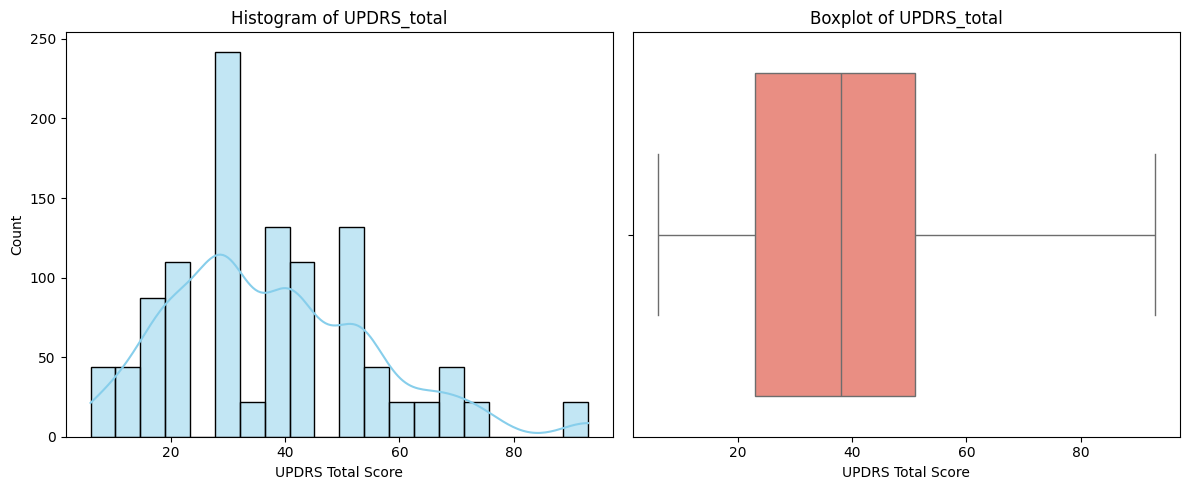


🧾 UPDRS Severity Range:
count    1099.000000
mean       37.676979
std        18.139068
min         6.000000
25%        23.000000
50%        38.000000
75%        51.000000
max        93.000000
Name: UPDRS_total, dtype: float64

🎯 Example tasks with valid UPDRS entries:
Task
DDK analysis        300
sentences           300
modulated vowels    250
sentences2          200
read text            49
Name: UPDRS_total, dtype: int64


In [ ]:
# --- Step 8: Visualization of UPDRS ---
df_valid = df_merged.dropna(subset=["UPDRS_total"]).copy()
df_valid["UPDRS_total"] = df_valid["UPDRS_total"].astype(float)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_valid["UPDRS_total"], bins=20, kde=True, color="skyblue")
plt.title("Histogram of UPDRS_total")
plt.xlabel("UPDRS Total Score")

plt.subplot(1, 2, 2)
sns.boxplot(x=df_valid["UPDRS_total"], color="salmon")
plt.title("Boxplot of UPDRS_total")
plt.xlabel("UPDRS Total Score")

plt.tight_layout()
plt.show()

# --- Step 9: Optional Summary ---
print("\n UPDRS Severity Range:")
print(df_valid["UPDRS_total"].describe())

print("\n Example tasks with valid UPDRS entries:")
print(df_valid.groupby("Task")["UPDRS_total"].count().sort_values(ascending=False).head())


### Demographic and Clinical Feature Visualization

To understand the structure and balance of the dataset, several exploratory plots were generated:

- **Age Distribution by Label**  
  A histogram showing the age spread across the two diagnostic categories (Parkinson's Disease vs. Healthy Controls). This helps reveal any age imbalance that might affect model performance.

- **Hoehn & Yahr Stage Distribution**  
  A count plot of the Hoehn and Yahr stages, which reflect the severity of Parkinson's disease. This aids in understanding how severity levels are distributed in the dataset.

- **UPDRS Total Score by Gender**  
  A boxplot illustrating how the total UPDRS scores vary between male and female participants. This analysis can highlight potential gender-specific effects in disease severity.

- **UPDRS Total Score by Speech Task**  
  A boxplot showing the variation of UPDRS scores across different speech tasks. This informs which tasks might be more sensitive to detecting disease severity, guiding their prioritization in model development.

These visualizations assist in identifying data imbalances, clinical diversity, and patterns that are critical when designing classification and regression models.


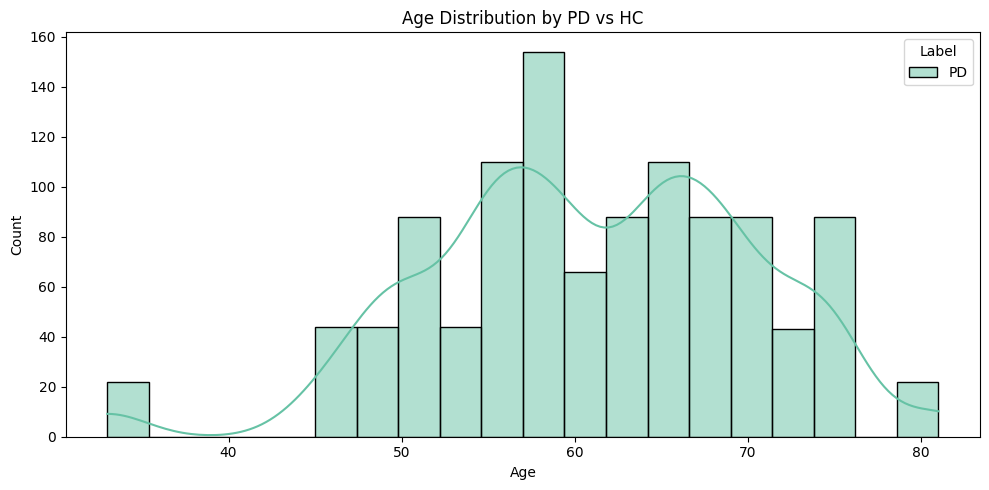

/tmp/ipython-input-58-1625146130.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Hoehn_Yahr", order=sorted(df["Hoehn_Yahr"].dropna().unique()), palette="pastel")


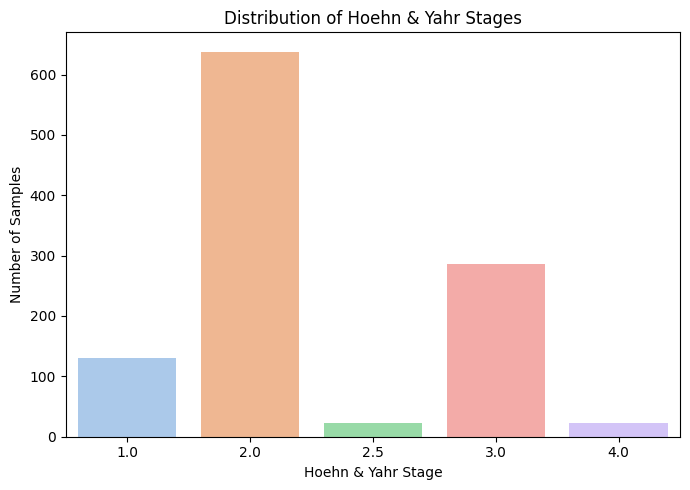

/tmp/ipython-input-58-1625146130.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_valid, x="Gender", y="UPDRS_total", palette="Set3")


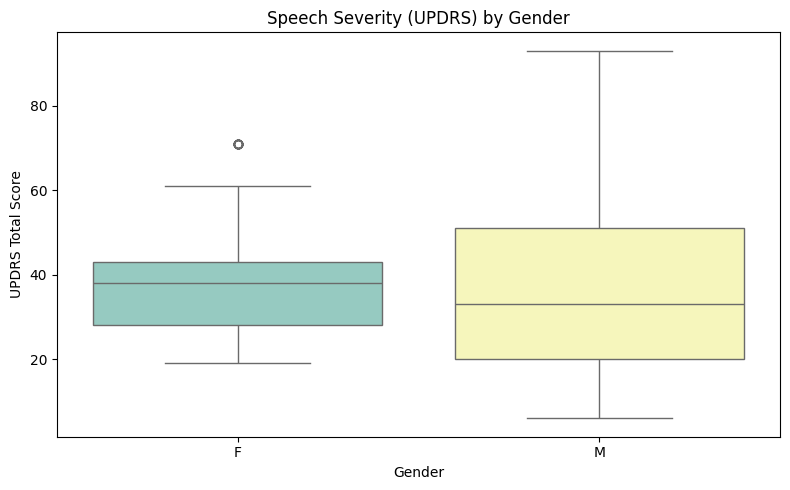

/tmp/ipython-input-58-1625146130.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_valid, x="Task", y="UPDRS_total", palette="muted")


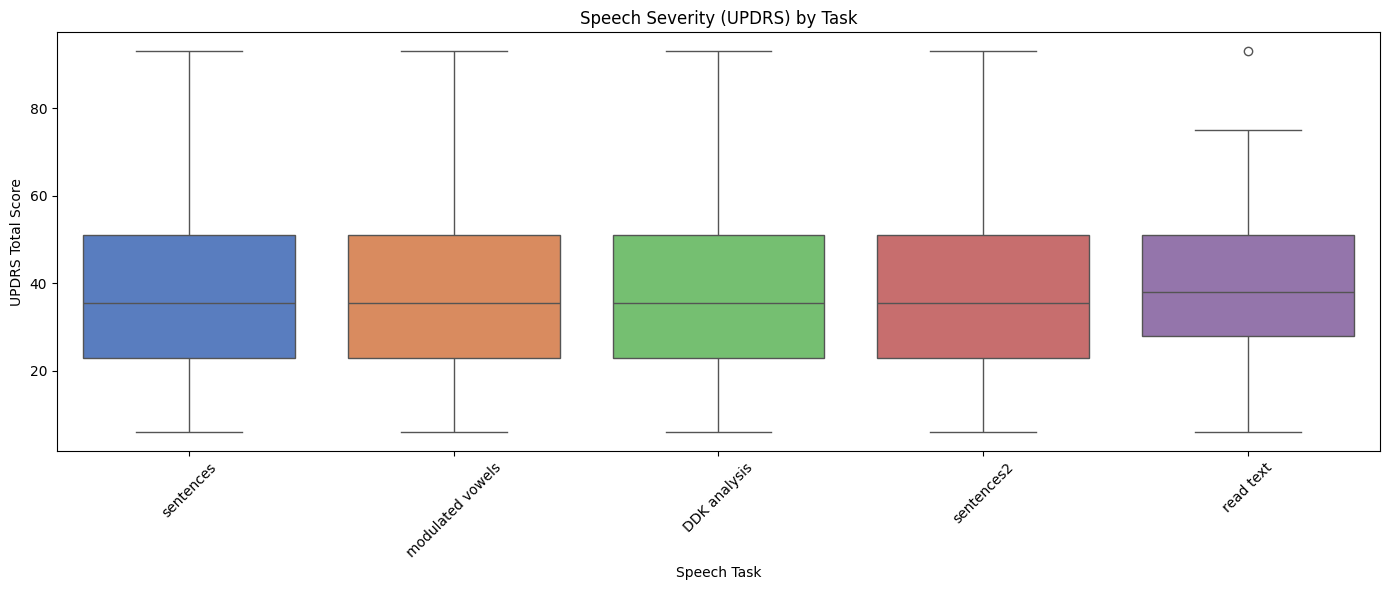

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated merged dataset
df = pd.read_csv("/content/drive/MyDrive/PCGITA_RESULTS/pcgita_metadata_cleaned.csv")

# === Age distribution plot by Label (PD vs HC) ===
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Age", hue="Label", multiple="stack", bins=20, palette="Set2", kde=True)
plt.title("Age Distribution by PD vs HC")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()  #  Show the plot

# === Hoehn & Yahr stage breakdown ===
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Hoehn_Yahr", order=sorted(df["Hoehn_Yahr"].dropna().unique()), palette="pastel")
plt.title("Distribution of Hoehn & Yahr Stages")
plt.xlabel("Hoehn & Yahr Stage")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()  #  Show the plot

# === Speech severity (UPDRS_total) vs Gender (boxplot) ===
df_valid = df.dropna(subset=["UPDRS_total", "Gender"])
df_valid["UPDRS_total"] = df_valid["UPDRS_total"].astype(float)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_valid, x="Gender", y="UPDRS_total", palette="Set3")
plt.title("Speech Severity (UPDRS) by Gender")
plt.xlabel("Gender")
plt.ylabel("UPDRS Total Score")
plt.tight_layout()
plt.show()  #  Show the plot

# === Speech severity vs Task (boxplot) ===
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_valid, x="Task", y="UPDRS_total", palette="muted")
plt.title("Speech Severity (UPDRS) by Task")
plt.xlabel("Speech Task")
plt.ylabel("UPDRS Total Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  #  Show the plot


# Severity Level Definition and UPDRS Normalization

To enable severity classification and standardized regression modeling, we performed the following preprocessing steps:

- **Severity Classification**  
  Based on clinical interpretation, we converted continuous UPDRS total scores into discrete severity levels:
  - **Mild**: UPDRS ≤ 32
  - **Moderate**: 32 < UPDRS ≤ 58
  - **Severe**: UPDRS > 58

  A bar plot was generated to visualize the class distribution.

- **UPDRS Distribution per Task**  
  A violin plot was used to inspect how severity (UPDRS total score) varies across speech tasks, helping identify which tasks reflect more severe symptoms.

- **Score Normalization**  
  - **Min-Max Scaling** to [0, 1]
  - **Z-score Standardization** (mean = 0, std = 1)

  A histogram was plotted to compare both normalization methods.

- **Cross-Validation Setup**  
  - **Classification folds** based on the categorical `Severity Level`
  - **Regression folds** based on quantile-binned `UPDRS_total` (into 5 equal-frequency bins)

These steps ensure robust and balanced data partitions for both classification and regression models.


/tmp/ipython-input-72-4144977799.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Severity Level", palette="pastel", order=["Mild", "Moderate", "Severe"])


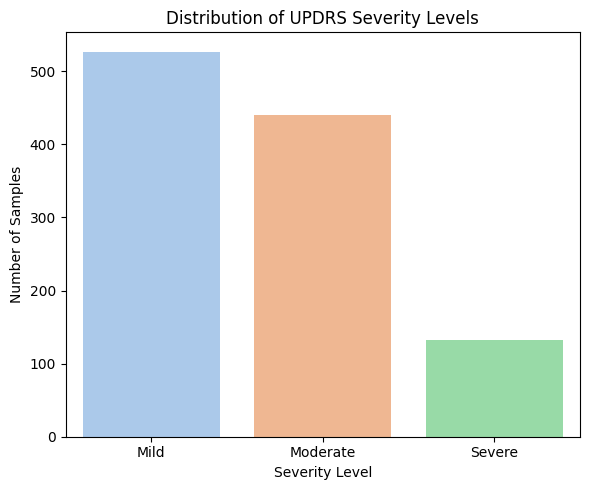

/tmp/ipython-input-72-4144977799.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Task", y="UPDRS_total", palette="muted")


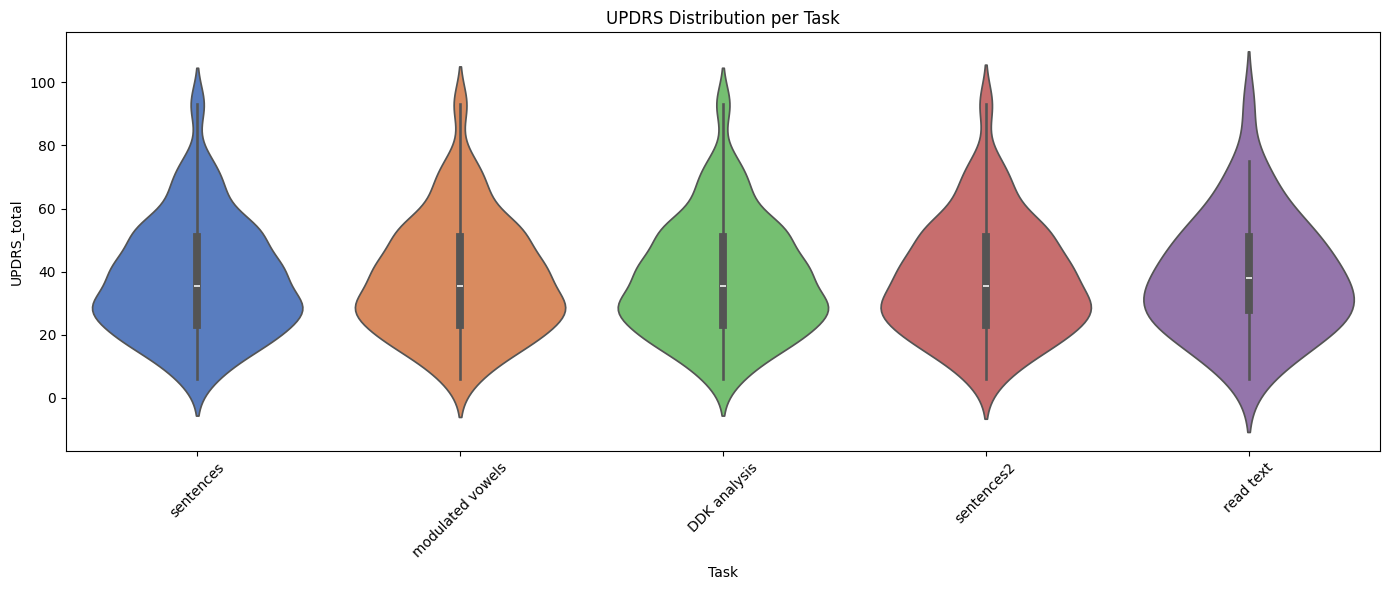

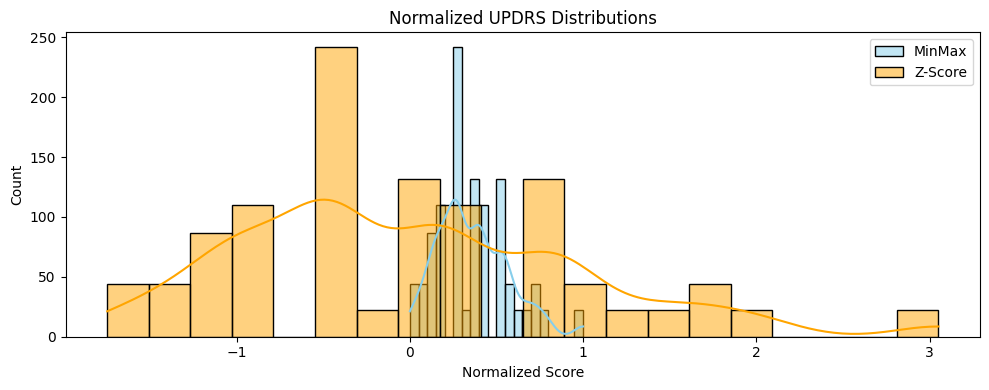

✅ Updated dataset saved as 'pcgita_final_with_norm.csv'

📁 Stratified classification splits by Severity Level
Fold 1: Train = 879, Val = 220
Fold 2: Train = 879, Val = 220
Fold 3: Train = 879, Val = 220
Fold 4: Train = 879, Val = 220
Fold 5: Train = 880, Val = 219

📁 Stratified regression splits by UPDRS bins (q=5)
Fold 1: Train = 879, Val = 220
Fold 2: Train = 879, Val = 220
Fold 3: Train = 879, Val = 220
Fold 4: Train = 879, Val = 220
Fold 5: Train = 880, Val = 219


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold

# === Step 1: Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/PCGITA_RESULTS/pcgita_metadata_cleaned.csv")
df = df[df["UPDRS_total"].notna()].copy()
df["UPDRS_total"] = df["UPDRS_total"].astype(float)

# === Step 2: Define Severity Levels (Based on Clinical Interpretation) ===
def updrs_to_severity(score):
    if score <= 32:
        return "Mild"
    elif score <= 58:
        return "Moderate"
    else:
        return "Severe"

df["Severity Level"] = df["UPDRS_total"].apply(updrs_to_severity)

# === Step 3: Plot Severity Level Distribution ===
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="Severity Level", palette="pastel", order=["Mild", "Moderate", "Severe"])
plt.title("Distribution of UPDRS Severity Levels")
plt.xlabel("Severity Level")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# === Step 4: Violin Plot - UPDRS per Task ===
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="Task", y="UPDRS_total", palette="muted")
plt.title("UPDRS Distribution per Task")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Step 5: Normalize UPDRS Scores ===
df["UPDRS_minmax"] = MinMaxScaler().fit_transform(df["UPDRS_total"].values.reshape(-1, 1))
df["UPDRS_zscore"] = StandardScaler().fit_transform(df["UPDRS_total"].values.reshape(-1, 1))

# === Step 6: Plot Normalized Distributions ===
plt.figure(figsize=(10, 4))
sns.histplot(df["UPDRS_minmax"], bins=20, color="skyblue", label="MinMax", kde=True)
sns.histplot(df["UPDRS_zscore"], bins=20, color="orange", label="Z-Score", kde=True)
plt.title("Normalized UPDRS Distributions")
plt.xlabel("Normalized Score")
plt.legend()
plt.tight_layout()
plt.show()

# === Step 7: Save Updated CSV ===
df.to_csv("/content/drive/MyDrive/PCGITA_RESULTS/pcgita_final_with_norm.csv", index=False)
print(" Updated dataset saved as 'pcgita_final_with_norm.csv'")

# === Step 8: Stratified K-Fold Splits ===
print("\n Stratified classification splits by Severity Level")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["Severity Level"])):
    print(f"Fold {fold+1}: Train = {len(train_idx)}, Val = {len(val_idx)}")

# Bin continuous values for regression folds
df["UPDRS_bin"] = pd.qcut(df["UPDRS_total"], q=5, labels=False, duplicates="drop")

print("\n Stratified regression splits by UPDRS bins (q=5)")
skf_reg = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf_reg.split(df, df["UPDRS_bin"])):
    print(f"Fold {fold+1}: Train = {len(train_idx)}, Val = {len(val_idx)}")


# Audio Indexing, Preprocessing, and Feature Extraction

full audio processing pipeline and extracts acoustic features from all `.wav` recordings in the PC-GITA dataset.

####  Audio Indexing & Metadata Mapping
- All `.wav` files are indexed from the dataset directory.
- Each recording is matched to a `Speaker_ID`, speech `Task`, and `Label` (PD or HC).
- Clinical metadata (UPDRS score, age, gender, etc.) is retrieved from a previously cleaned CSV.
- Output is saved as `pcgita_index_clean.csv`.

####  GroupKFold Splitting (Stratified by Speaker)
- We apply **GroupKFold** cross-validation (n=5) using `Speaker_ID` as the grouping key.
- This prevents speaker leakage between training and validation sets.
- Resulting splits are saved in `pcgita_index_split.csv`.

####  Audio Preprocessing
- Each audio file is:
  - Trimmed to remove silence
  - Resampled to 16 kHz for consistency
- Optional **data augmentation** includes:
  - Time-stretching
  - Pitch shifting
  - Gaussian noise injection

####  Acoustic Feature Extraction
From each preprocessed file, we extract:
- **MFCCs (13 coefficients)** + **delta** + **delta-delta** → averaged across time
- **Jitter** and **Shimmer** using Praat via `parselmouth`
- **Formants** (F1, F2, F3) at the midpoint of the utterance

####  Output
All extracted features are saved in a structured CSV:

pcgita_features_clean.csv

This serves as the main input for all downstream models (SVM, RF, LSTM, CNN-LSTM, XGBoost, etc.)



In [ ]:
# ------------------- SETUP -------------------
from google.colab import drive
drive.mount('/content/drive')

!pip install -q librosa soundfile praat-parselmouth joblib tqdm

import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from joblib import Parallel, delayed
import librosa
import parselmouth

# ------------------- PATHS -------------------
ROOT = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz"
METADATA_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_metadata_cleaned.csv"
OUT_DIR = "/content/drive/MyDrive/PCGITA_RESULTS"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------- LOAD METADATA -------------------
def load_metadata(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.replace(" ", "_")
    if "Speaker ID" in df.columns:
        df = df.rename(columns={"Speaker ID": "Speaker_ID"})
    df = df.dropna(subset=["Speaker_ID"])
    df = df.drop_duplicates(subset=["Speaker_ID"])
    print(" Metadata columns:", df.columns.tolist())
    return df

metadata_df = load_metadata(METADATA_PATH)
speaker_meta = metadata_df.set_index("Speaker_ID").to_dict(orient="index")

# ------------------- WAV INDEXING -------------------
def parse_wav_index(root):
    records = []
    for dirpath, _, files in os.walk(root):
        for f in files:
            if not f.lower().endswith(".wav"):
                continue
            full_path = os.path.join(dirpath, f)
            rel_path = os.path.relpath(full_path, root)
            parts = Path(rel_path).parts
            task = parts[0]
            speaker_id = next((spk for spk in speaker_meta if f.startswith(spk)), None)
            label = "PD" if "parkinson" in rel_path.lower() or "patologica" in rel_path.lower() else "HC"
            meta = speaker_meta.get(speaker_id, {
                "UPDRS_total": np.nan,
                "Hoehn_Yahr": np.nan,
                "Gender": "Unknown",
                "Age": np.nan,
                "After_Diagnosis": np.nan
            })
            records.append({
                "Task": task,
                "Label": label,
                "Speaker_ID": speaker_id if speaker_id else "Unknown",
                "Relative_Path": rel_path,
                "Full_Path": full_path,
                "UPDRS_total": meta["UPDRS_total"],
                "Hoehn_Yahr": meta["Hoehn_Yahr"],
                "Gender": meta["Gender"],
                "Age": meta["Age"],
                "After_Diagnosis": meta["After_Diagnosis"]
            })
    return pd.DataFrame(records)

df = parse_wav_index(ROOT)
df = df[df["Label"].isin(["PD", "HC"])]
df.to_csv(f"{OUT_DIR}/pcgita_index_clean.csv", index=False)
print(f" Indexed {len(df)} .wav files.")

# ------------------- GROUPKFOLD SPLIT -------------------
def add_groupkfold_split(df, n_splits=5):
    df = df.copy()
    df["group_label"] = df["Label"] + "_" + df["Task"]
    splitter = GroupKFold(n_splits=n_splits)
    df["split"] = "none"
    for fold, (train_idx, val_idx) in enumerate(splitter.split(df, df["group_label"], groups=df["Speaker_ID"])):
        df.loc[val_idx, "split"] = f"val{fold+1}"
        df.loc[train_idx, "split"] = f"train{fold+1}"
    return df

df = add_groupkfold_split(df)
df.to_csv(f"{OUT_DIR}/pcgita_index_split.csv", index=False)
print(" Saved GroupKFold split file.")

# ------------------- AUDIO FUNCTIONS -------------------
def normalize_audio(path, target_sr=16000):
    y, sr = librosa.load(path, sr=None)
    y, _ = librosa.effects.trim(y)
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y, target_sr

def augment_audio(y, sr, apply_time_stretch=True, pitch_shift=True, noise=True):
    if apply_time_stretch:
        rate = np.random.uniform(0.85, 1.15)
        y = librosa.effects.time_stretch(y, rate)
    if pitch_shift:
        steps = np.random.randint(-2, 3)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
    if noise:
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y = y + noise_amp * np.random.normal(size=y.shape)
    return y

# ------------------- FEATURE EXTRACTION -------------------
apply_augmentation = False  # Set to True if needed

def extract_features(row):
    path = row["Full Path"]
    try:
        y, sr = normalize_audio(path)
        if apply_augmentation:
            y = augment_audio(y, sr)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Handle short sequences: if fewer than 9 frames, delta will fail
        if mfcc.shape[1] >= 9:
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)
        else:
            delta = np.zeros_like(mfcc)
            delta2 = np.zeros_like(mfcc)

        # Flatten MFCC features
        mfcc_feats = np.concatenate([mfcc, delta, delta2], axis=0).mean(axis=1)

        # Parselmouth features
        snd = parselmouth.Sound(path)
        pp = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
        jitter = parselmouth.praat.call(pp, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        shimmer = parselmouth.praat.call([snd, pp], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        formants = snd.to_formant_burg()
        f1 = formants.get_value_at_time(1, snd.duration / 2)
        f2 = formants.get_value_at_time(2, snd.duration / 2)
        f3 = formants.get_value_at_time(3, snd.duration / 2)

        return row.to_dict() | {
            **{f"mfcc{i+1}": v for i, v in enumerate(mfcc_feats)},
            "jitter": jitter,
            "shimmer": shimmer,
            "formant1": f1,
            "formant2": f2,
            "formant3": f3
        }
    except Exception as e:
        print(f" Failed: {path} → {e}")
        return None

# ------------------- RUN EXTRACTION -------------------
print(" Extracting features in parallel...")
feature_rows = Parallel(n_jobs=4, backend="multiprocessing")(
    delayed(extract_features)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

df_features = pd.DataFrame([r for r in feature_rows if r is not None])
df_features.to_csv(f"{OUT_DIR}/pcgita_features_clean.csv", index=False)
print(f" Feature CSV saved: {df_features.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  6%|▋         | 403/6414 [03:12<47:44,  2.10it/s]


🔍 Metadata columns: ['Task', 'Label', 'Speaker_ID', 'Relative_Path', 'Full_Path', 'UPDRS_total', 'Updrs-Speech', 'Hoehn_Yahr', 'Gender', 'Age', 'After_Diagnosis']
✅ Indexed 6414 .wav files.
✅ Saved GroupKFold split file.
🚀 Extracting features in parallel...



  2%|▏         | 128/6414 [00:14<09:32, 10.98it/s]

⚠️ Failed: /content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz/Words/Sin normalizar/Patologica/ñame/AVPEPUDEA0025ñame.wav → when mode='interp', width=9 cannot exceed data.shape[axis]=8



 20%|█▉        | 1252/6414 [01:45<08:47,  9.78it/s]

⚠️ Failed: /content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz/Words/Sin normalizar/Patologica/coco/AVPEPUDEA0048coco.wav → when mode='interp', width=9 cannot exceed data.shape[axis]=8



100%|██████████| 6414/6414 [22:03<00:00,  4.85it/s]


✅ Feature CSV saved: (6412, 56)


### 🔹 Acoustic Feature Exploration and Visualization

To analyze the distribution, variance, and separability of the extracted acoustic features, a series of exploratory plots were generated:

- ** Jitter vs Shimmer Scatterplot**  
  Visualizes the relationship between frequency (jitter) and amplitude (shimmer) perturbation across classes (PD vs HC), useful for observing natural variability in dysphonic speech.

- ** MFCC Violin Plots**  
  Displays the distribution of the first 13 MFCC coefficients for both classes. These features capture the phonetic envelope and are essential in speech pathology analysis.

- ** Class Distribution Plot**  
  A count plot to inspect the balance between Parkinson's Disease (PD) and Healthy Control (HC) samples.

- ** Violin Plots for Other Features**  
  Includes jitter, shimmer, and formants (F1–F3), illustrating how these vocal tract characteristics differ between groups.

- ** PCA and t-SNE Projections**  
  Two unsupervised dimensionality reduction techniques were applied to high-dimensional feature vectors:
  - **PCA (Principal Component Analysis)**: Preserves global variance
  - **t-SNE (t-distributed Stochastic Neighbor Embedding)**: Preserves local neighborhood structure  

- ** Correlation Heatmap**  
  A heatmap of Pearson correlations between features, useful for identifying multicollinearity or redundant variables.

All plots were saved under the `/PCGITA_RESULTS/plots/` directory.


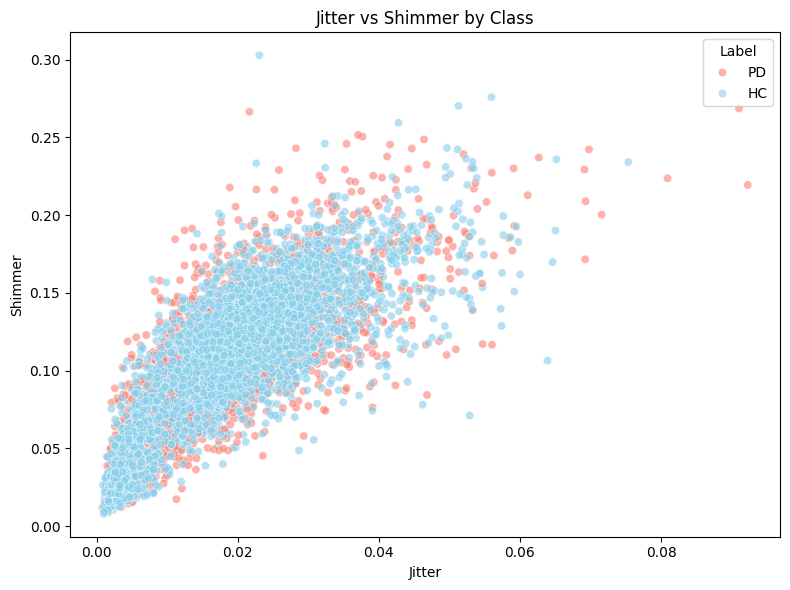

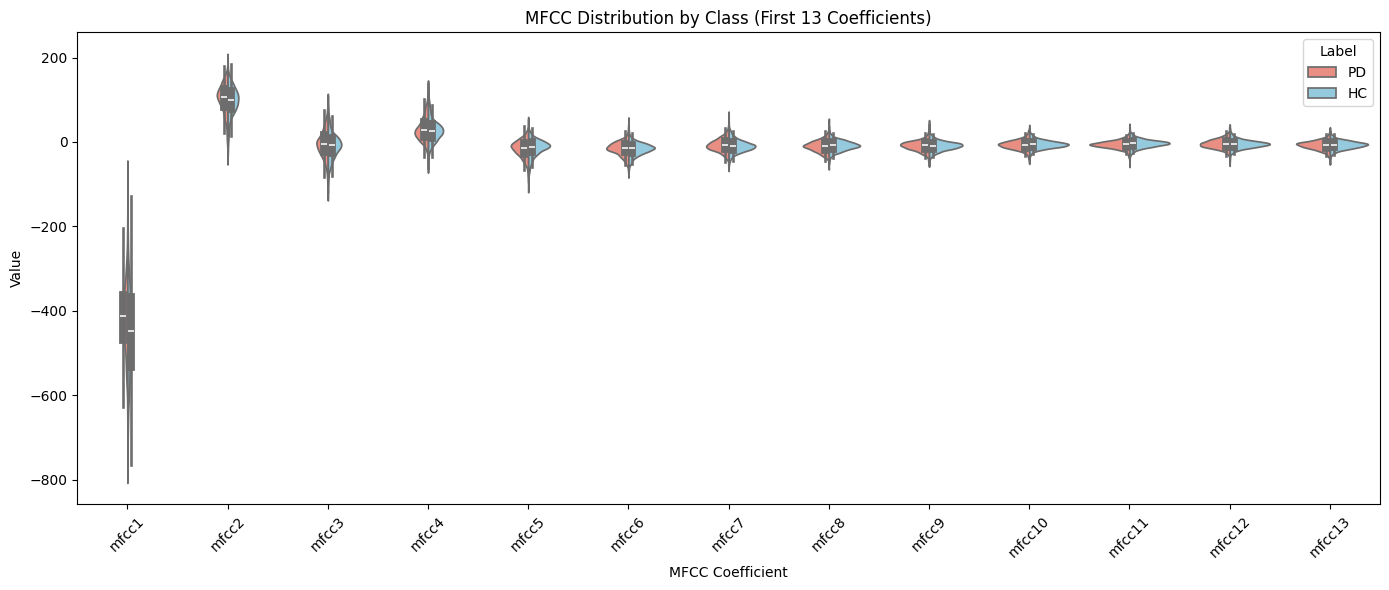

/tmp/ipython-input-65-870299956.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=label_col, palette=palette)


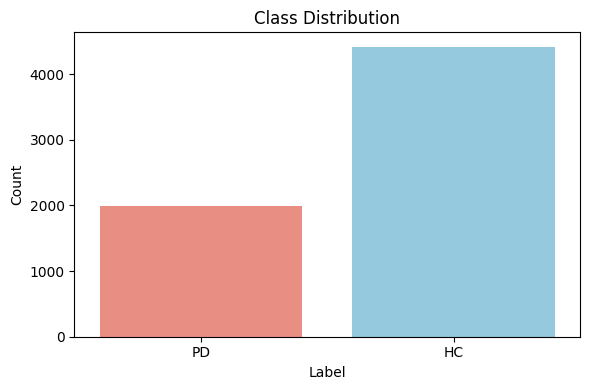

/tmp/ipython-input-65-870299956.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=label_col, y=col, palette=palette)


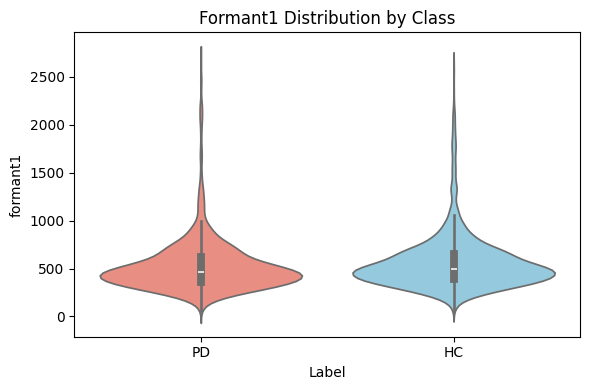

/tmp/ipython-input-65-870299956.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=label_col, y=col, palette=palette)


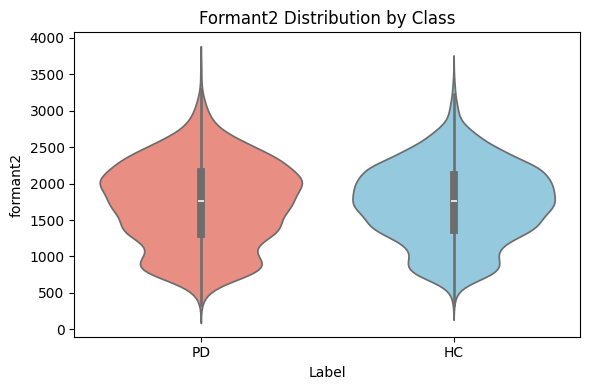

/tmp/ipython-input-65-870299956.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=label_col, y=col, palette=palette)


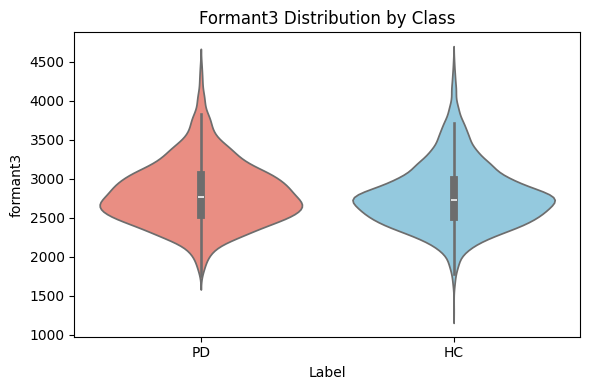

/tmp/ipython-input-65-870299956.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=label_col, y=col, palette=palette)


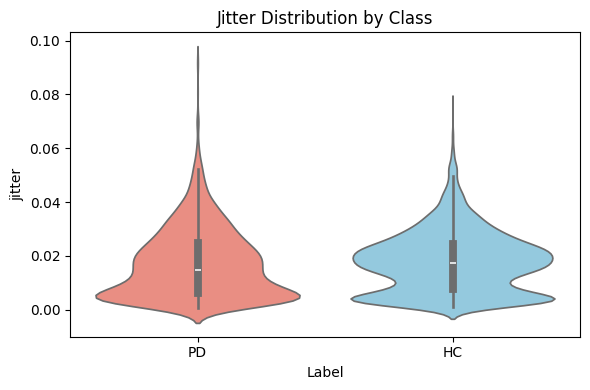

/tmp/ipython-input-65-870299956.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=label_col, y=col, palette=palette)


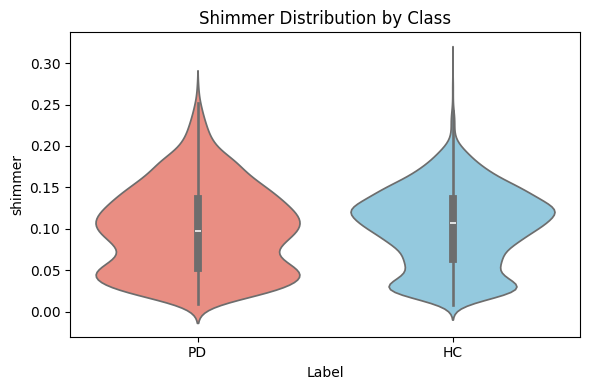

PCA Explained Variance Ratio: [0.0853439  0.06251451]


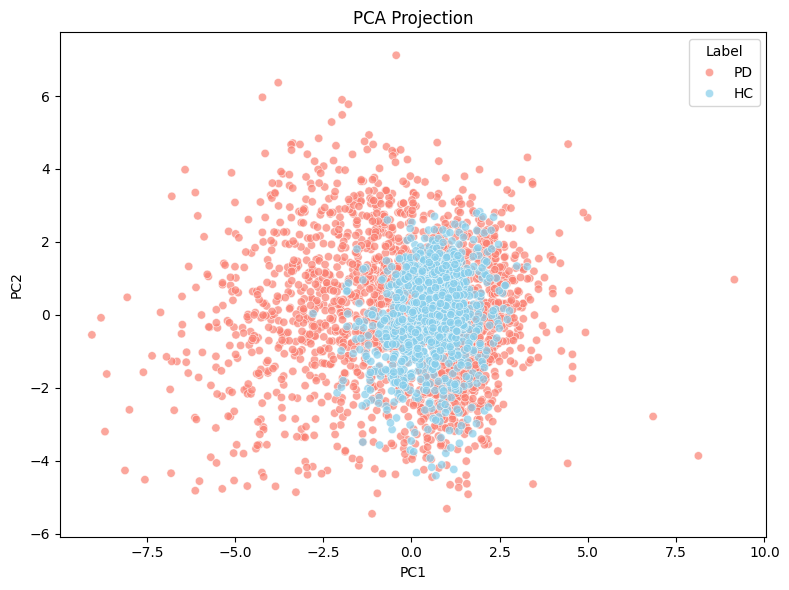

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


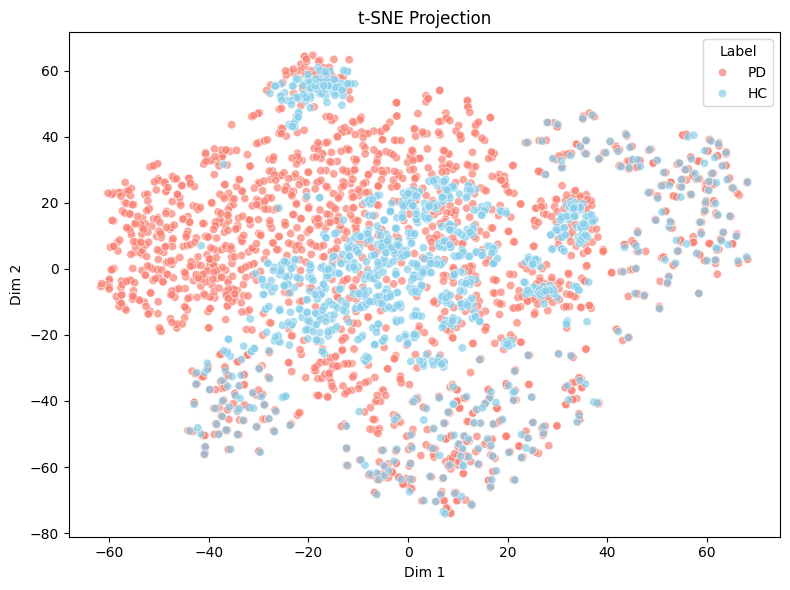

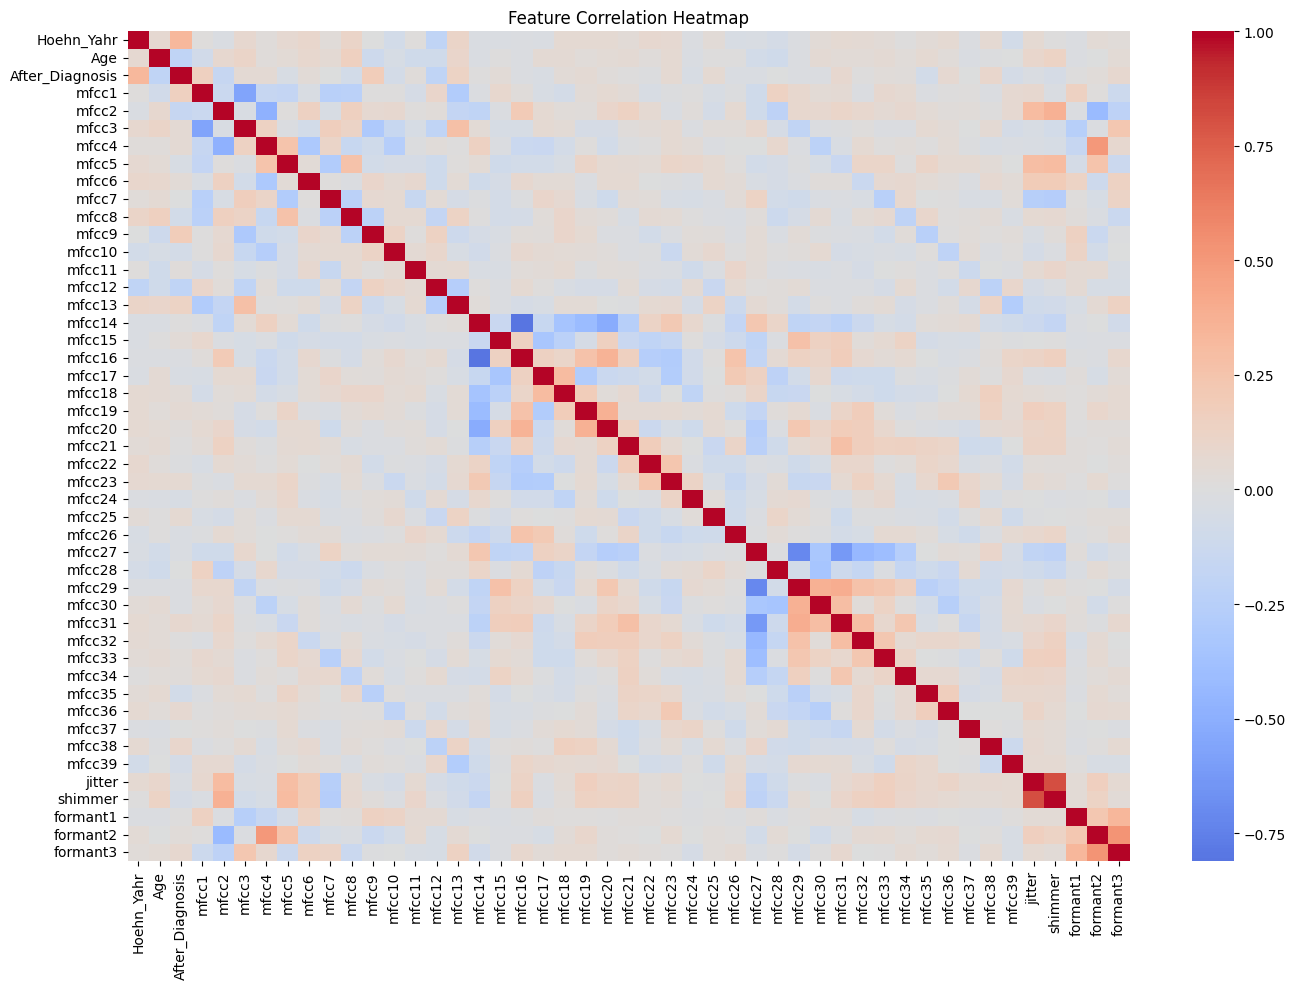

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import os

# ------------------- Load Dataset -------------------
df = pd.read_csv("/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv")

# ------------------- Auto-detect Label Column -------------------
label_col = "label" if "label" in df.columns else "Label"
palette = {"HC": "skyblue", "PD": "salmon"}

# Optional plot output dir
plot_dir = "/content/drive/MyDrive/PCGITA_RESULTS/plots"
os.makedirs(plot_dir, exist_ok=True)

# ------------------- Jitter vs Shimmer Scatter -------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="jitter", y="shimmer", hue=label_col, alpha=0.6, palette=palette)
plt.title("Jitter vs Shimmer by Class")
plt.xlabel("Jitter")
plt.ylabel("Shimmer")
plt.tight_layout()
plt.savefig(f"{plot_dir}/jitter_shimmer_scatter.png")
plt.show()

# ------------------- Violin Plot: MFCC 1-13 -------------------
mfcc_cols = [f"mfcc{i+1}" for i in range(13)]
df_melted = df.melt(id_vars=[label_col], value_vars=mfcc_cols,
                    var_name="MFCC Coefficient", value_name="Value")

plt.figure(figsize=(14, 6))
sns.violinplot(data=df_melted, x="MFCC Coefficient", y="Value", hue=label_col, split=True, palette=palette)
plt.title("MFCC Distribution by Class (First 13 Coefficients)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{plot_dir}/mfcc_violin.png")
plt.show()

# ------------------- Class Count -------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=label_col, palette=palette)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(f"{plot_dir}/class_distribution.png")
plt.show()

# ------------------- Violin Plots: Formants & Perturbation -------------------
cols_to_plot = ["formant1", "formant2", "formant3", "jitter", "shimmer"]
for col in cols_to_plot:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df, x=label_col, y=col, palette=palette)
    plt.title(f"{col.capitalize()} Distribution by Class")
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/{col}_violin.png")
    plt.show()

# ------------------- PCA Visualization -------------------
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in numeric_cols if col not in ["severity_score", "UPDRS_total"]]

df_clean = df.dropna(subset=feature_cols + [label_col])
X = df_clean[feature_cols]
y = df_clean[label_col]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.7, palette=palette)
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(f"{plot_dir}/pca_projection.png")
plt.show()

# ------------------- t-SNE Visualization -------------------
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, alpha=0.7, palette=palette)
plt.title("t-SNE Projection")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.savefig(f"{plot_dir}/tsne_projection.png")
plt.show()

# ------------------- Correlation Heatmap -------------------
plt.figure(figsize=(14, 10))
corr_matrix = df_clean[feature_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{plot_dir}/correlation_heatmap.png")
plt.show()
